In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2


from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)




PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [4]:
# Load SP500 panel, as long as we can reasonably go
prices = load_sp500_adj_close(start="2000-01-01")
prices = load_sp500_adj_close(start="2000-01-01", force_download=True)

prices.info()
prices.head()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))


Universe size from CSV: 503
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 50)
  -> Batch close shape: (6529, 3)
Final price panel shape: (6529, 503)
Saved S&P 500 adj close to C:\Users\gehra\Documents\GitHub\Quant_coding\data\sp500_adj_close.parquet
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6529 entries, 2000-01-03 to 2025-12-16
Columns: 503 entries, NVDA to NWS
dtypes: float64(503)
memory usage: 25.1 MB
Price panel shape: (6529, 503)
Date range: 2000-01-03 00:00:00 -> 2025-12-16 00:00:00
Number of tickers: 503


In [5]:
lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

signals_df.head()
print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))




c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2763866, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-14 00:00:00
Unique tickers in signals: 500


X shape: (2763866, 11)
y shape: (2763866,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-14 00:00:00
Num unique tickers: 500


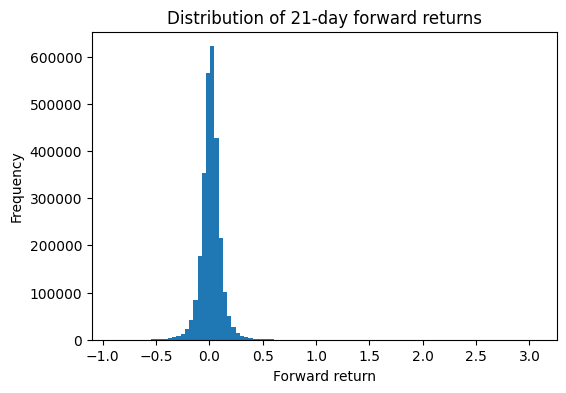

In [6]:
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity checks on target distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [7]:
# --- Date-based split: train / val / test ---

unique_dates = np.array(sorted(dates.unique()))
n_dates = len(unique_dates)
print("Number of trading days in panel:", n_dates)

# 60% train, 20% val, 20% test by time
train_end = unique_dates[int(n_dates * 0.6)]
val_end   = unique_dates[int(n_dates * 0.8)]

print("Train end date:", train_end)
print("Val   end date:", val_end)

mask_train = dates <= train_end
mask_val   = (dates > train_end) & (dates <= val_end)
mask_test  = dates > val_end

X_train, y_train = X[mask_train], y[mask_train]
X_val,   y_val   = X[mask_val],   y[mask_val]
X_test,  y_test  = X[mask_test],  y[mask_test]

dates_train = dates[mask_train]
dates_val   = dates[mask_val]
dates_test  = dates[mask_test]
tickers_test = tickers[mask_test]

print("Train samples:", len(y_train))
print("Val   samples:", len(y_val))
print("Test  samples:", len(y_test))


Number of trading days in panel: 6309
Train end date: 2015-11-03 00:00:00
Val   end date: 2020-11-06 00:00:00
Train samples: 1542740
Val   samples: 597674
Test  samples: 623452


In [8]:
# --- Baseline cross-sectional momentum on TEST period ---

# We'll use signals_df again but only for dates > val_end
idx_dates = signals_df.index.get_level_values("date")
signals_test = signals_df.loc[idx_dates > val_end].copy()

signals_test.head()


ret_1     ret_5    ret_10    ret_21    vol_10    vol_20  \
date       ticker                                                               
2020-11-09 NVDA   -0.063951  0.083461  0.037249 -0.009591  0.042495  0.031598   
           AAPL   -0.019968  0.071257  0.012783 -0.003841  0.033942  0.025264   
           MSFT   -0.023824  0.079375  0.039556  0.011955  0.027996  0.021581   
           AMZN   -0.050623  0.046351 -0.019738 -0.043482  0.037594  0.027113   
           GOOGL   0.000960  0.084404  0.111804  0.166156  0.030316  0.024517   

                     vol_60  ma20_rel  ma50_rel  ma200_rel  target_fwd_21  dow  
date       ticker                                                               
2020-11-09 NVDA    0.032967 -0.008805 -0.029159  -0.295456      -0.051074    0  
           AAPL    0.028764 -0.004981 -0.005092  -0.213809       0.046940    0  
           MSFT    0.021924 -0.019740 -0.030668  -0.126016      -0.027636    0  
           AMZN    0.026178  0.023989  0.017712  -0.153616      -0.012577    0  
           GOOGL   0.021759 -0.082366 -0.118974  -0.187127       0.009333    0

In [9]:
def daily_momentum_cs(group: pd.DataFrame, q: float = 0.1, horizon: int = 21) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()

    # convert 21-day returns to daily-equivalent returns
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily   = to_daily(eqw_ret_21)
    long_ret_daily  = to_daily(long_ret_21)
    short_ret_daily = to_daily(short_ret_21)
    long_short_daily = long_ret_daily - short_ret_daily

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


In [10]:
daily_cs_rets = signals_test.groupby("date").apply(daily_momentum_cs, q=0.1)
daily_cs_rets.head()

eqw_returns        = daily_cs_rets["eqw"]
mom_long_returns   = daily_cs_rets["long"]
mom_ls_returns     = daily_cs_rets["long_short"]


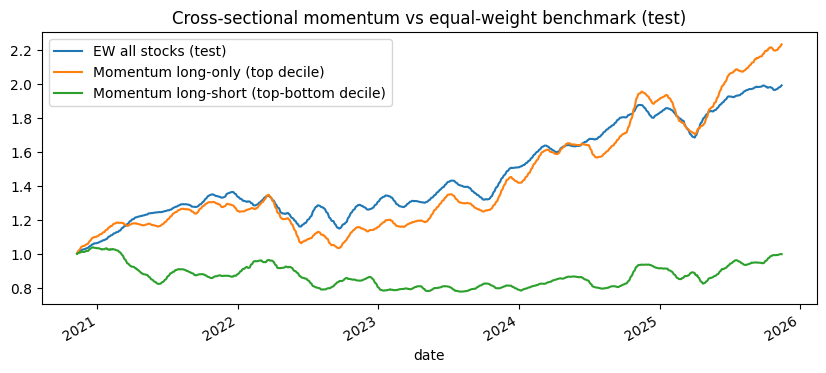

{'eqw_cagr': 0.1471457360031756,
 'eqw_vol': np.float64(0.031926288003343184),
 'eqw_sharpe': np.float64(4.648408162091673),
 'eqw_max_dd': -0.15781487492263335,
 'momL_cagr': 0.17340172853106028,
 'momL_vol': np.float64(0.04007863083060587),
 'momL_sharpe': np.float64(4.374100734863752),
 'momL_max_dd': -0.2332283095294112,
 'momLS_cagr': -0.0003161275692495913,
 'momLS_vol': np.float64(0.039050000665130744),
 'momLS_sharpe': np.float64(0.015692558206594424),
 'momLS_max_dd': -0.2512352592182371}

In [11]:
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)

equity_eqw     = equity_curve_from_returns(eqw_returns)
equity_mom_L   = equity_curve_from_returns(mom_long_returns)
equity_mom_LS  = equity_curve_from_returns(mom_ls_returns)

plt.figure(figsize=(10, 4))
equity_eqw.plot(label="EW all stocks (test)")
equity_mom_L.plot(label="Momentum long-only (top decile)")
equity_mom_LS.plot(label="Momentum long-short (top-bottom decile)")
plt.legend()
plt.title("Cross-sectional momentum vs equal-weight benchmark (test)")
plt.show()

metrics_cs = {
    "eqw_cagr":     cagr(equity_eqw),
    "eqw_vol":      annualized_vol(eqw_returns),
    "eqw_sharpe":   sharpe_ratio(eqw_returns),
    "eqw_max_dd":   max_drawdown(equity_eqw),

    "momL_cagr":    cagr(equity_mom_L),
    "momL_vol":     annualized_vol(mom_long_returns),
    "momL_sharpe":  sharpe_ratio(mom_long_returns),
    "momL_max_dd":  max_drawdown(equity_mom_L),

    "momLS_cagr":   cagr(equity_mom_LS),
    "momLS_vol":    annualized_vol(mom_ls_returns),
    "momLS_sharpe": sharpe_ratio(mom_ls_returns),
    "momLS_max_dd": max_drawdown(equity_mom_LS),
}
metrics_cs


In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

# --- Cross-sectional tree regressor baseline ---

tree_cs = HistGradientBoostingRegressor(
    max_depth=5,
    learning_rate=0.05,
    max_iter=300,
    min_samples_leaf=50,
    random_state=42,
)

tree_cs.fit(X_train, y_train)

print("Train R^2:", tree_cs.score(X_train, y_train))
print("Val   R^2:", tree_cs.score(X_val,   y_val))


Train R^2: 0.06186374543219442
Val   R^2: -0.026861198054772606


In [13]:
# Predictions on the test samples (cross-sectional)
y_pred_test = tree_cs.predict(X_test)

df_test = pd.DataFrame(
    {
        "date":   dates_test,
        "symbol": tickers_test,
        "y_true": y_test,
        "y_pred": y_pred_test,
    }
).set_index(["date", "symbol"]).sort_index()

df_test.head()


y_true    y_pred
date       symbol                    
2020-11-09 A       0.034667  0.009016
           AAPL    0.046940  0.020753
           ABBV    0.142451  0.010332
           ABT    -0.028065  0.012842
           ACGL   -0.025842  0.004146

In [14]:
def daily_model_cs(group: pd.DataFrame, q: float = 0.1, horizon: int = 21) -> pd.Series:
    """
    Cross-sectional ML ranking for a single date.

    group: rows for one date, many tickers, with columns:
        y_true: true forward 21-day return
        y_pred: model predicted 21-day return
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon in days (21 here).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # Equal-weight benchmark: hold all stocks
    eqw_ret_21 = group["y_true"].mean()

    # Sort by predicted forward return
    g_sorted = group.sort_values("y_pred")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]    # worst predicted
    top    = g_sorted.iloc[-k:]   # best predicted

    long_ret_21  = top["y_true"].mean()
    short_ret_21 = bottom["y_true"].mean()

    # Convert 21-day returns to daily-equivalent
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_daily      = to_daily(eqw_ret_21)
    long_daily     = to_daily(long_ret_21)
    short_daily    = to_daily(short_ret_21)
    long_short_dly = long_daily - short_daily

    return pd.Series(
        {
            "eqw": eqw_daily,
            "long": long_daily,
            "long_short": long_short_dly,
        }
    )


In [15]:
tree_cs_rets = df_test.groupby("date").apply(daily_model_cs, q=0.1, horizon=21)
tree_cs_rets.head()

tree_eqw_returns   = tree_cs_rets["eqw"]          # should be close to your EW benchmark
tree_long_returns  = tree_cs_rets["long"]
tree_ls_returns    = tree_cs_rets["long_short"]


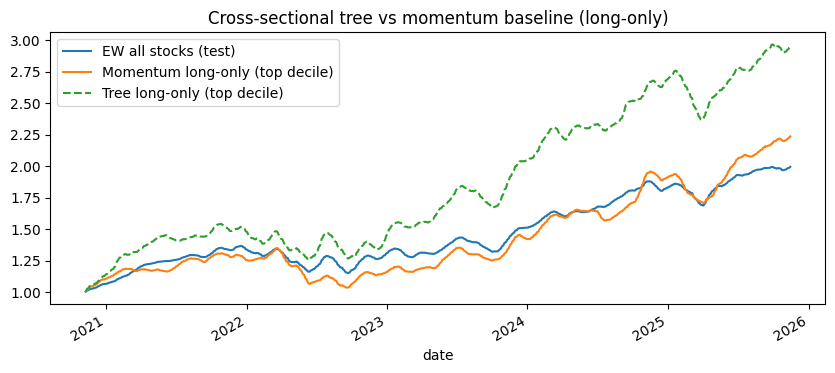

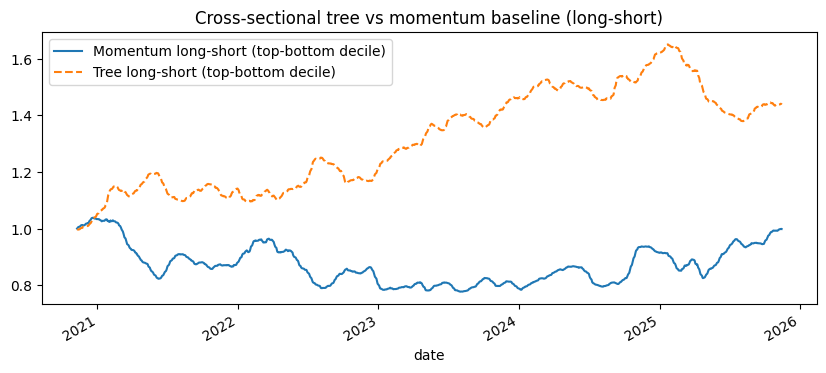

In [16]:
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)

equity_tree_L   = equity_curve_from_returns(tree_long_returns)
equity_tree_LS  = equity_curve_from_returns(tree_ls_returns)

plt.figure(figsize=(10, 4))
equity_eqw.plot(label="EW all stocks (test)")
equity_mom_L.plot(label="Momentum long-only (top decile)")
equity_tree_L.plot(label="Tree long-only (top decile)", linestyle="--")
plt.legend()
plt.title("Cross-sectional tree vs momentum baseline (long-only)")
plt.show()

plt.figure(figsize=(10, 4))
equity_mom_LS.plot(label="Momentum long-short (top-bottom decile)")
equity_tree_LS.plot(label="Tree long-short (top-bottom decile)", linestyle="--")
plt.legend()
plt.title("Cross-sectional tree vs momentum baseline (long-short)")
plt.show()


In [17]:
metrics_tree_cs = {
    "momL_cagr":    cagr(equity_mom_L),
    "momL_vol":     annualized_vol(mom_long_returns),
    "momL_sharpe":  sharpe_ratio(mom_long_returns),
    "momL_max_dd":  max_drawdown(equity_mom_L),

    "treeL_cagr":   cagr(equity_tree_L),
    "treeL_vol":    annualized_vol(tree_long_returns),
    "treeL_sharpe": sharpe_ratio(tree_long_returns),
    "treeL_max_dd": max_drawdown(equity_tree_L),

    "momLS_cagr":   cagr(equity_mom_LS),
    "momLS_vol":    annualized_vol(mom_ls_returns),
    "momLS_sharpe": sharpe_ratio(mom_ls_returns),
    "momLS_max_dd": max_drawdown(equity_mom_LS),

    "treeLS_cagr":  cagr(equity_tree_LS),
    "treeLS_vol":   annualized_vol(tree_ls_returns),
    "treeLS_sharpe":sharpe_ratio(tree_ls_returns),
    "treeLS_max_dd":max_drawdown(equity_tree_LS),
}

metrics_tree_cs


{'momL_cagr': 0.17340172853106028,
 'momL_vol': np.float64(0.04007863083060587),
 'momL_sharpe': np.float64(4.374100734863752),
 'momL_max_dd': -0.2332283095294112,
 'treeL_cagr': 0.24063765818431193,
 'treeL_vol': np.float64(0.046643821023060174),
 'treeL_sharpe': np.float64(5.208788832415917),
 'treeL_max_dd': -0.1854202151298523,
 'momLS_cagr': -0.0003161275692495913,
 'momLS_vol': np.float64(0.039050000665130744),
 'momLS_sharpe': np.float64(0.015692558206594424),
 'momLS_max_dd': -0.2512352592182371,
 'treeLS_cagr': 0.0765925839955921,
 'treeLS_vol': np.float64(0.030600775220825445),
 'treeLS_sharpe': np.float64(2.5051141130813703),
 'treeLS_max_dd': -0.16412627696990967}